# Felügyelet nélküli tanulás

Olvasd el a felügyelet nélküli tanulás [előadás leckéjét](http://www.inf.u-szeged.hu/~rfarkas/ML20/unsupervised.html)! Két felügyelet nélküli gépi tanulási alkalmazást, a klaszterezést és a dimenzió csökkentést tárgyaltuk. Nézzünk ezekre egy-egy példát a [MovieLens adatbázis](https://grouplens.org/datasets/movielens/)t adatbázison.

## Klaszterezés

A klaszterezés célja, hogy az címkézetlen adatból csoportulásokat (klasztereket) azonosítsok. Klaszterezzük a MovieLens (részlet) adatbázis filmjeit a leírásuk (`plot`) alapján! 

In [ ]:
import pandas as pd
item_colnames = ['movieID', # ezzel tudjuk összekötni az értékelésekkel
                 'title', # film címe, aztán zárójelben a bemutató éve
                 'genre', # műfaj címkék
                 'plot', # rövid tartalmi leírás
                 'actors' # színészek
                 ] 
movies = pd.read_csv('https://github.com/rfarkas/student_data/raw/main/MovieLens/movielens.item.info', sep='\t', names=item_colnames, encoding='latin-1')
movies.head()

,movieID,title,genre,plot,actors
0,1,Toy Story (1995),"Animation,Children's,Comedy",A little boy named Andy loves to be in his roo...,"Bradley, Lisa (I);Derryberry, Debi;Freeman, Sa..."
1,2,GoldenEye (1995),"Action,Adventure,Thriller",When a deadly satellite weapon system falls in...,"Arthur, Michelle (I);Bond, Samantha (I);Dench,..."
2,3,Four Rooms (1995),Thriller,This movie features the collaborative director...,"Beals, Jennifer;Bellais, Monica Lee (I);Blair,..."
3,4,Get Shorty (1995),"Action,Comedy,Drama","Some guys get all the luck, whether they like ...","Arthur, Rebeca (I);Bega, Leslie;Burke, Carleas..."
4,5,Copycat (1995),"Crime,Drama,Thriller",Criminal profiler and psychologist Dr Helen Hu...,"Amos, Diane;Bingham, Gena;Bryson, Edith;Carmon..."


In [ ]:
movies.shape

(1682, 5)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

bow_extractor = CountVectorizer()
features = bow_extractor.fit_transform(movies['plot'])

ValueError: ignored

In [ ]:
### NaN-okat kezelnünk kell valahogy...
print(movies.shape , movies["plot"].dropna().shape) # ~400 filmet elveszítünk. De aminek nincs plotja, azzal egyébként se tudunk mit kezdeni...
df = movies[movies["plot"].notna()] # azokkal a sorokkal dolgozunk csak, amiknél a plot nem NaN

(1682, 5) (1286,)


In [ ]:
features = bow_extractor.fit_transform(df['plot'])
features # ~20K méretű szótár, annyi jellemző

<1286x19441 sparse matrix of type '<class 'numpy.int64'>'
	with 148802 stored elements in Compressed Sparse Row format>

In [ ]:
# így lassan fut majd minden a colabon :(
# a ritka szavakra nincs szükségünk
bow_extractor = CountVectorizer(min_df=10) # csak azok a szavak amik legalább 10 szövegben szerepelnek
features = bow_extractor.fit_transform(df['plot'])
features # ~2300 méretű lett a szótár

<1286x2304 sparse matrix of type '<class 'numpy.int64'>'
	with 111614 stored elements in Compressed Sparse Row format>

In [ ]:
# k-közép klaszterezés a szózsák jellemzők felett számolt Euklideszi távolságok alapján
from sklearn.cluster import KMeans
k=5
kmeans = KMeans(n_clusters=k).fit(features) 

In [ ]:
kmeans.labels_ # tartalmazza az egyes egyedekhez rendelt klaszterIDt

array([1, 1, 0, ..., 0, 3, 1], dtype=int32)

In [ ]:
# Nézzünk rá a tanult klaszterekre!
# Gyűjtsük ki az egyes klaszterekbe tartozó egyedindexeket
cluster = {}
for j in range(k):
  cluster[j] = [i for i, e in enumerate(kmeans.labels_) if e == j] # j. klaszterbe sorolt egyedek indexei

In [ ]:
# Klaszter méretek
for j in cluster:
  print(j, ". klaszter mérete:", len(cluster[j]))

0 . klaszter mérete: 302
1 . klaszter mérete: 81
2 . klaszter mérete: 87
3 . klaszter mérete: 28
4 . klaszter mérete: 114
5 . klaszter mérete: 33
6 . klaszter mérete: 7
7 . klaszter mérete: 58
8 . klaszter mérete: 195
9 . klaszter mérete: 381


In [ ]:
df.title.head(50)

In [ ]:
# Példa filmek egyes klaszterekből
for j in range(k):  
  print("klaszter",j)
  for i in range(3):
    print(df.title.iloc[ cluster[j][i] ]) # ilocot kell használnunk mert a dropna() miatt a dataframe nevek (=indexek) nem egyeznek a jellemzővektorok indexeivel, amin a klaszterzés ment
  print("----------")

klaszter 0
Four Rooms (1995)
Copycat (1995)
Babe (1995)
----------
klaszter 1
Dead Man Walking (1995)
The Usual Suspects (1995)
From Dusk Till Dawn (1996)
----------
klaszter 2
Toy Story (1995)
GoldenEye (1995)
Twelve Monkeys (1995)
----------
klaszter 3
Sleepless in Seattle (1993)
Home Alone (1990)
The Rock (1996)
----------
klaszter 4
The Birdcage (1996)
Apollo 13 (1995)
Strange Days (1995)
----------
klaszter 5
Star Wars (1977)
Stargate (1994)
Jurassic Park (1993)
----------
klaszter 6
Outbreak (1995)
A Time to Kill (1996)
Titanic (1997)
----------
klaszter 7
Belle de jour (1967)
The Net (1995)
While You Were Sleeping (1995)
----------
klaszter 8
Richard III (1995)
Mighty Aphrodite (1995)
Braveheart (1995)
----------
klaszter 9
Get Shorty (1995)
Free Willy 2: The Adventure Home (1995)
Nadja (1994)
----------


Látunk értelmes klasztereket? :)

## 2 dimenzióra csökkentés

A dimenzió csökkentés célja, hogy olyan kis dimeznziós térbe képezze le az egyedeinket ahol a kis dimenzióban egymáshoz közeli pontok hasonlóak legyenek egymáshoz az eredeti térben és azok a pontpárok akik távol vannak egymástól kevésbé hasonlítanak egymáshoz. Az Singular Value Decompostion (SVD) algoritmus pont így helyezi el egy kis dimenziós vektortérben az egyedeket.

Vizualizáljuk a MovieLens adatbázis filmjeit (termékeit) 2D-ben, úgy hogy azok a filmek legyenek közel egymáshoz akiknek hasonló a leírásuk (`plot`).

In [ ]:
### SVD dimenzió csökkentés:
# ha 2D a cél, akkor a két legnagyobb sajátértékhez tartozó sajátvektorokat vegyük csak figyelembe
# ezeket az oszlopokat fel tudjuk használni arra, hogy vizualizáljunk
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=2) # az első 2 komponenst tartjuk csak meg (2Dbe mappelünk)
m2d = svd.fit_transform(features) # az adatbázison megcsinálja a leképezést
m2d # a 2300 dimenziós szózsák bináris jellemzőtérből minden plotot egy 2D vektorra képezünk le

array([[31.64697447, -9.59458128],
       [37.60306258, -2.57162693],
       [10.60541781,  1.17449095],
       ...,
       [ 7.77357902, -2.95378435],
       [17.16167206, -3.72615749],
       [34.0661926 , -1.21901095]])

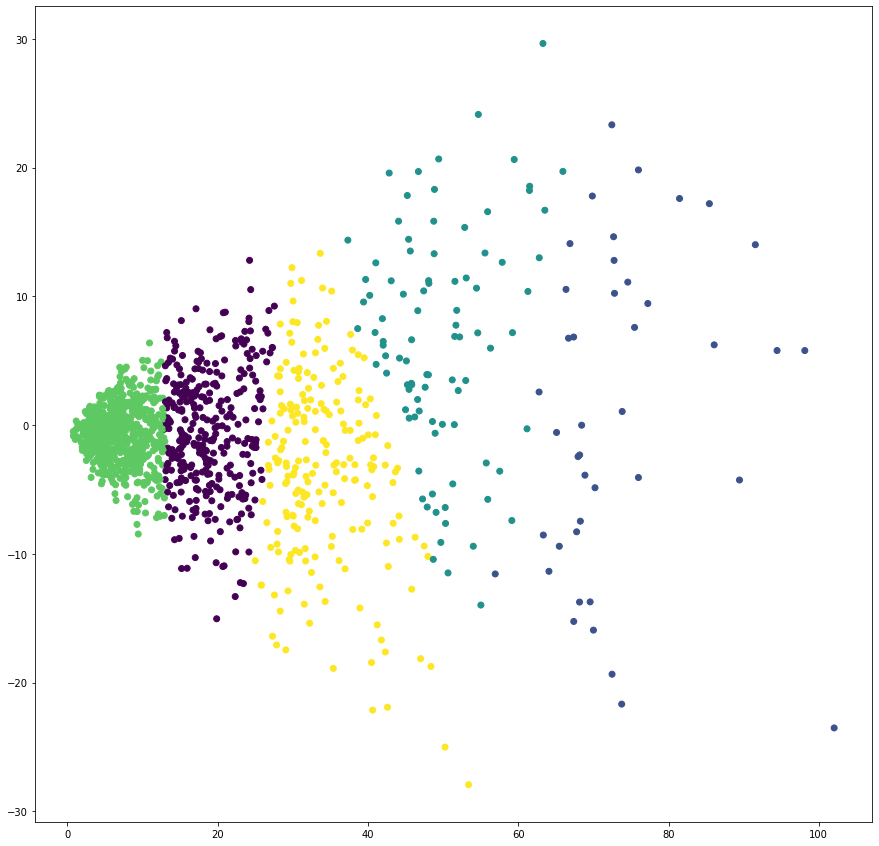

In [ ]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(15,15))       # beállítjuk a kép méretét, a default érték pici
plt.scatter( m2d[:,0],   # minden pont egy film, aminek x koordinátája az SVD leképezés első komponense
             m2d[:,1],   # y koordinátája az SVD leképezés második komponense (2D)
             c=kmeans.labels_) # színe pedig a korábban kiszámolt k-means klaszterket jelöli

Jól látható, hogy az SVD 2D leképezés jól megörzi a páronkénti hasonlóságat, hiszen a klaszterezés az eredeti 2300 dimenziós szózsák jellemzőtér hasonlósági értékei alapján történt, és a 2D leképezés után a klaszterek jól elkülönülnek a 2D térben is.

# Gyakorló feladatok

1. Az alábbi arcérzelem képi adatbázisból vegyük az első 50 képet. Vizualizáljuk ezeket a képeket 2D-ben, úgy, hogy a hasonló képek közelebb vannak egymáshoz!

2. A arcérzelem adatbázist klaszterezzük és minden klaszterből néhány egyedet jelenítsünk meg a 2D térben!

In [ ]:
# Kezelhető méretű részhalmaz a https://www.kaggle.com/c/emotion-detection-from-facial-expressions adatbázisból
import pandas as pd
data = pd.read_csv('https://github.com/rfarkas/student_data/raw/main/images/fer2013_1K.csv')

In [ ]:
#48x48 szürke képek egy stringbe vannak kódolva. A 11. kép kiolvasása így megy:
import numpy as np
image = np.reshape(np.asarray(data.pixels[11].split(' '), np.uint8), (48,48))
plt.imshow(image, cmap="gray")